In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
pd.options.mode.chained_assignment = None

### Step 1: Load Data and Perform Transformation (Use Combination and GetDummies)

In [2]:
df = pd.read_csv('telco.csv')

In [3]:
df = df.drop(['customerID','TotalCharges'],axis=1)

In [4]:
df.loc[df['MultipleLines']=='No phone service','MultipleLines'] = 'No'
df.loc[df['OnlineSecurity']=='No internet service','OnlineSecurity'] = 'No'
df.loc[df['OnlineBackup']=='No internet service','OnlineBackup'] = 'No'
df.loc[df['DeviceProtection']=='No internet service','DeviceProtection'] = 'No'
df.loc[df['TechSupport']=='No internet service','TechSupport'] = 'No'
df.loc[df['StreamingTV']=='No internet service','StreamingTV'] = 'No'
df.loc[df['StreamingMovies']=='No internet service','StreamingMovies'] = 'No'

In [5]:
Tweet_df = pd.read_csv('TweetSentiment.csv')

In [6]:
Tweet_df.head(5)

,Tweet,Polarity
0,Making sure you get the most out of T-Mobile T...,0.445312
1,The Note was just launched. I'm so glad that I...,0.166667
2,I get penalized for being broke with my T-Mob...,0.000000
3,Just changed my Sprint SIM card for a T-mobile...,-0.015152
4,Oh I hear you! Between my wife and me we are ...,0.000000


In [7]:
x = df.drop('Churn',axis=1)

In [8]:
x = pd.get_dummies(x)

In [9]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
SeniorCitizen                              7043 non-null int64
tenure                                     7043 non-null int64
MonthlyCharges                             7043 non-null float64
gender_Female                              7043 non-null uint8
gender_Male                                7043 non-null uint8
Partner_No                                 7043 non-null uint8
Partner_Yes                                7043 non-null uint8
Dependents_No                              7043 non-null uint8
Dependents_Yes                             7043 non-null uint8
PhoneService_No                            7043 non-null uint8
PhoneService_Yes                           7043 non-null uint8
MultipleLines_No                           7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
InternetService_DSL                        7043 non-null uint8
InternetS

In [10]:
y = df['Churn']

### Step 2: Cluster Customer Data and Assign Tweet Data

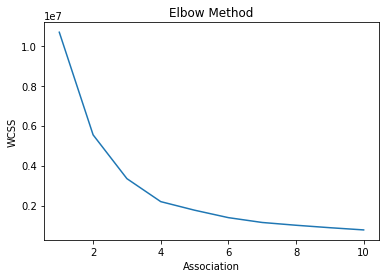

In [11]:
# apply k-means to the dataset to get clusters 
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [12]:
# Use k means to cluster 4 groups
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 400, 
                n_init = 10, random_state = 0)
label = kmeans.fit_predict(x)

In [13]:
# append label to original dataset 
x['cluster'] = label
x['Churn'] = y

In [15]:
# get subset for each cluster 
x_0 = x[x['cluster'] == 0]
x_1 = x[x['cluster'] == 1]
x_2 = x[x['cluster'] == 2]
x_3 = x[x['cluster'] == 3]

In [16]:
# get describtion of cluster
mean_val = {'x_0': x_0.mean(), 'x_1': x_1.mean(), 'x_2': x_2.mean(), 'x_3': x_3.mean()}
mean_val = pd.DataFrame(mean_val)

In [17]:
# extract important columns
mean_val.loc[['tenure', 'MonthlyCharges', 'PhoneService_Yes', 'MultipleLines_Yes', 'OnlineBackup_Yes',
             'InternetService_No', 'Contract_Two year', 'TechSupport_Yes', 'OnlineSecurity_Yes'], :]

,x_0,x_1,x_2,x_3
tenure,10.594842,58.583461,14.766697,54.169124
MonthlyCharges,32.643123,93.283002,81.085178,33.964224
PhoneService_Yes,0.797135,0.988259,0.993596,0.747615
MultipleLines_Yes,0.097994,0.761103,0.463861,0.255854
OnlineBackup_Yes,0.112894,0.677386,0.299177,0.217693
InternetService_No,0.493983,0.000000,0.000000,0.575889
Contract_Two year,0.100287,0.418581,0.022415,0.564614
TechSupport_Yes,0.116905,0.553344,0.240622,0.199480
OnlineSecurity_Yes,0.126074,0.537519,0.222324,0.225499


From previous observation of different clusters, we assume the order of probability of churn is below from highest to lowest:
1. Since customers in x_2 get high monthly charges but pretty low tenure, and its service is not good as x_1, so we assume customers in this group are high likely to churn.
2. Since customers in x_0 group get lowest tenure mean, and its service is poorest among all group though its price is not high, I will assume it gets second highest churn probability.
3. Since customers in x_1 get pretty good service among all groups but its price is the highest one, I will give it third rank.
4. Since for customers in x_3, the customers get pretty fair price and considerable service quality, and also we can see it has many old customers with long contract, I will assmue it has least probability of customer churn.

So the final rank of churn probability(highest to lowest): x_2 --> x_0 --> x_1 --> x_3

In [18]:
# print shape of clusters
print('x_0:', x_0.shape)
print('x_1:', x_1.shape)
print('x_2:', x_2.shape)
print('x_3:', x_3.shape)

x_0: (1745, 39)
x_1: (1959, 39)
x_2: (2186, 39)
x_3: (1153, 39)


In [19]:
# Then assign polarity to each group according to our clustering rank 
polarity = Tweet_df['Polarity']
polarity = sorted(polarity, reverse=False)

In [20]:
# Assign group for polarity according to the shape of clusters
polarity_0 = polarity[:2186]
polarity_1 = polarity[2186:3931]
polarity_2 = polarity[3931:5890]
polarity_3 = polarity[5890:7043]

In [21]:
# Resample the order in polarity group, so the value is randomly assigned
random.seed(2)
random.shuffle(polarity_0)
random.shuffle(polarity_1)
random.shuffle(polarity_2)
random.shuffle(polarity_3)

In [22]:
# assign the polarity to orignal data
x_2.loc[:,'Polarity'] = polarity_0
x_0.loc[:,'Polarity'] = polarity_1
x_1.loc[:,'Polarity'] = polarity_2
x_3.loc[:,'Polarity'] = polarity_3

In [23]:
x = pd.concat([x_0, x_1, x_2, x_3])
x = x.drop(['cluster'], axis=1)
x = x.sample(frac=1).reset_index(drop=True)
x = x.copy()

In [24]:
#x.to_csv('telco_with_polarity.csv', index=False)

### Step 3: Apply smote on new data with polarity and train the model

In [175]:
# please read the csv directly for next step
x = pd.read_csv('telco_with_polarity.csv')